In [11]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [12]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import keras

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical
import pickle
import pandas as pd
import random

In [15]:
np.random.seed(0)

In [16]:
from os import read
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)
print(type(train_data))
X_train, Y_train = train_data['features'], train_data['labels']
X_test, Y_test = test_data['features'], test_data['labels']
X_val, Y_val = val_data ['features'], val_data['labels']

<class 'dict'>


In [17]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [18]:
assert(X_train.shape[0] == Y_train.shape[0]), "The number of images is not equal to the number of lables"
assert(X_val.shape[0] == Y_val.shape[0]), "The number of images is not equal to the number of lables"
assert(X_test.shape[0] == Y_test.shape[0]), "The number of images is not equal to the number of lables"
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"

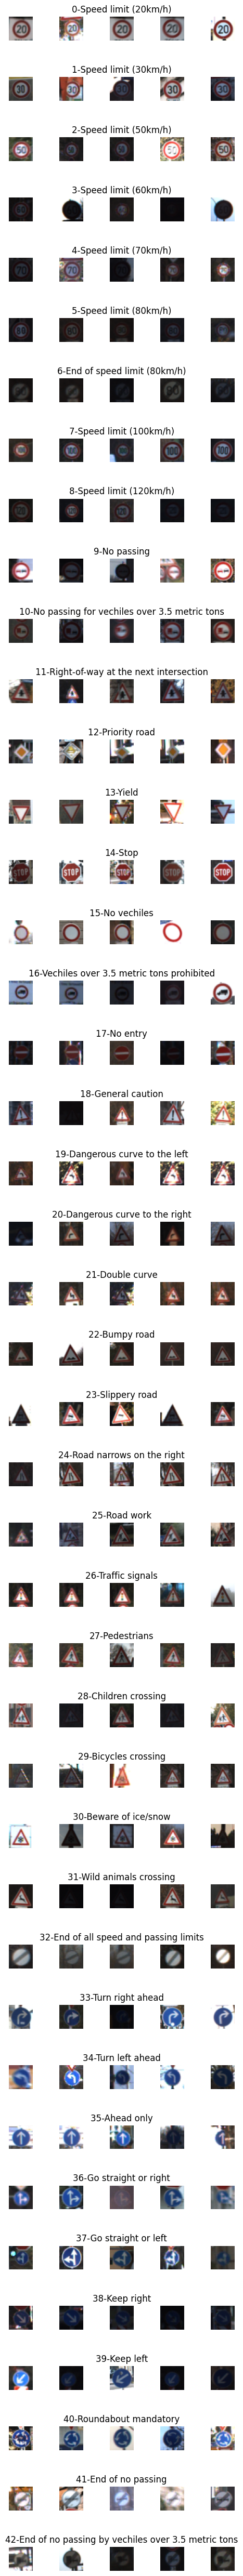

In [20]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[Y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+ "-" + row["SignName"])
            num_of_samples.append(len(x_selected))



[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

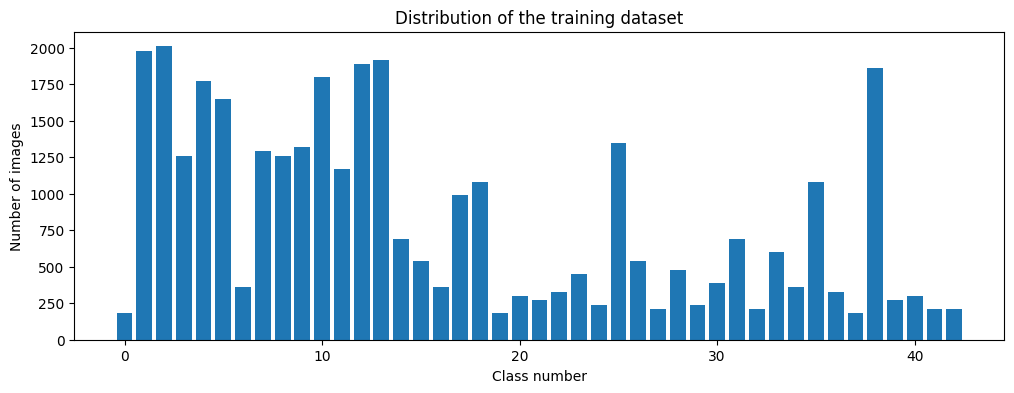

In [21]:
import cv2
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)
36


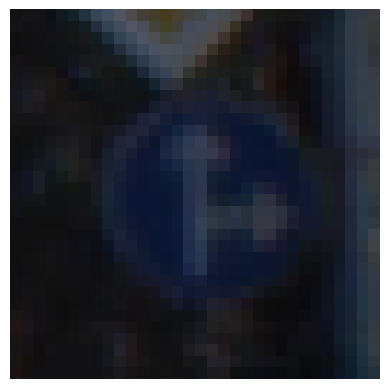

In [22]:
# Display an original image
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(Y_train[1000])

(32, 32)


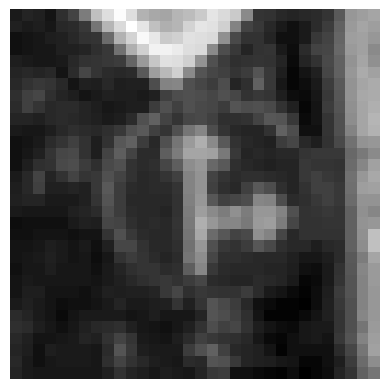

In [23]:
def grayscale(img):
    if img.ndim == 3:  # Check if the image has 3 channels (color)
        img = img.astype(np.uint8)  # Convert to uint8
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

img = grayscale(X_train[1000])
plt.imshow(img, cmap='gray') # Display the grayscale image using a grayscale colormap
plt.axis("off")
print(img.shape)


(32, 32)


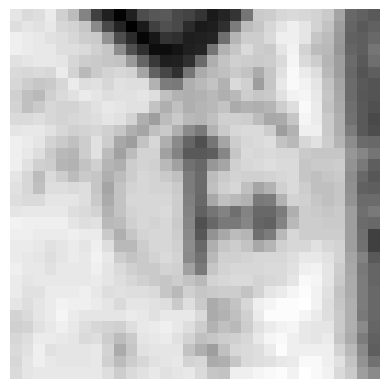

In [24]:
def invert_grayscale(img):
    return 255 - img

img = invert_grayscale(img)
plt.imshow(img, cmap='gray')
plt.axis("off")
print(img.shape)

(32, 32)


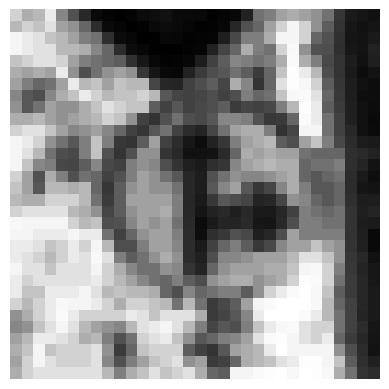

In [25]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
img = equalize(img)
plt.imshow(img, cmap='gray')
plt.axis("off")
print(img.shape)

In [26]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img




In [27]:
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32)
(12630, 32, 32)
(4410, 32, 32)


(-0.5, 31.5, 31.5, -0.5)

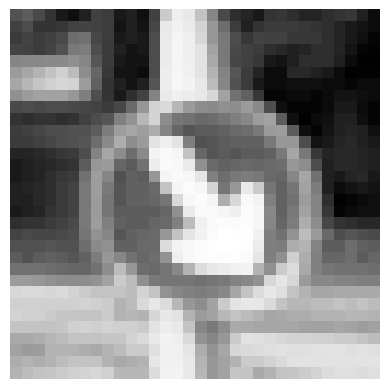

In [28]:
fig2 = plt.figure(2)
plt.imshow(X_train[random.randint(0, len(X_train)-1)], cmap = plt.get_cmap('gray'))
plt.axis('off')

In [29]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [30]:
#Data Augmentation
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator( width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, shear_range=0.1, rotation_range=10)
datagen.fit(X_train)

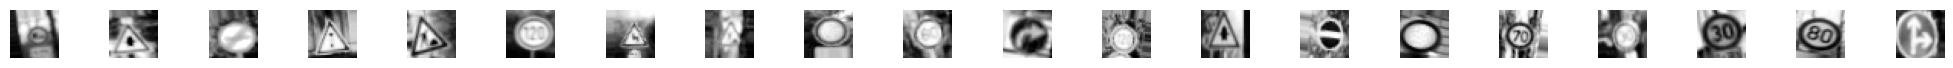

In [31]:
batches = datagen.flow(X_train, Y_train, batch_size=20)
X_batch, Y_batch = next(batches) # next function call the iterator item and retrieves the next item for it, we get 20 new images each time the iterator is called.

fig, axis = plt.subplots(1, 20, figsize=(20, 5))
fig.tight_layout()

for i in range(20):
    axis[i].imshow(X_batch[i].reshape(32, 32), cmap=plt.get_cmap('gray'))
    axis[i].axis('off')  # Hide the axes

# Set an increased batch size for training
batch_size = 100  # Increased batch size

In [32]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)


(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [33]:
Y_train = to_categorical(Y_train, 43)
Y_test = to_categorical(Y_test, 43)
Y_val = to_categorical(Y_val, 43)

In [34]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5,5), input_shape=(32,32,1), activation='relu'))
  model.add(Conv2D(60, (5,5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(30,(3,3), activation='relu'))
  model.add(Conv2D(30,(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  # Compile Model
  model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [35]:
model = modified_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 60)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 30)          0         
 g2D)                                                   

In [36]:
# Calculate steps per epoch
batch_size = 100
steps_per_epoch = len(X_train) // batch_size
print(f"Calculated steps per epoch: {steps_per_epoch}")

Calculated steps per epoch: 347


In [37]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size), steps_per_epoch=347, epochs=20, validation_data=(X_val, Y_val), shuffle=1)

Epoch 1/20
347/347 [==============================] - 21s 42ms/step - loss: 2.6147 - accuracy: 0.2780 - val_loss: 0.7858 - val_accuracy: 0.7850
Epoch 2/20
347/347 [==============================] - 13s 39ms/step - loss: 1.1467 - accuracy: 0.6463 - val_loss: 0.3648 - val_accuracy: 0.8800
Epoch 3/20
347/347 [==============================] - 15s 44ms/step - loss: 0.7801 - accuracy: 0.7595 - val_loss: 0.1972 - val_accuracy: 0.9399
Epoch 4/20
347/347 [==============================] - 14s 40ms/step - loss: 0.5955 - accuracy: 0.8146 - val_loss: 0.1403 - val_accuracy: 0.9601
Epoch 5/20
347/347 [==============================] - 14s 40ms/step - loss: 0.5002 - accuracy: 0.8436 - val_loss: 0.0900 - val_accuracy: 0.9791
Epoch 6/20
347/347 [==============================] - 14s 39ms/step - loss: 0.4160 - accuracy: 0.8701 - val_loss: 0.0990 - val_accuracy: 0.9732
Epoch 7/20
347/347 [==============================] - 14s 40ms/step - loss: 0.3817 - accuracy: 0.8802 - val_loss: 0.0812 - val_accuracy:

Text(0.5, 0, 'epoch')

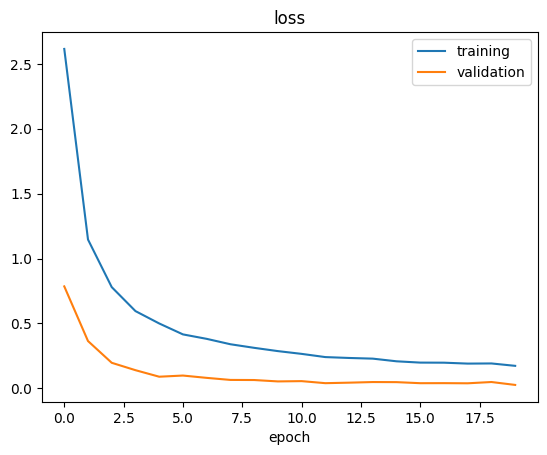

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

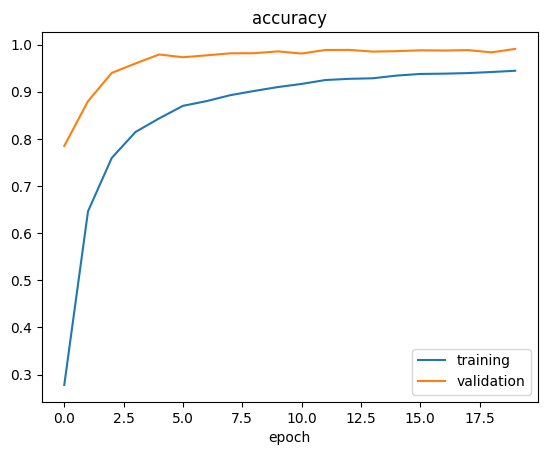

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('accuracy')
plt.xlabel('epoch')

In [40]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test Score: ', score[0])
print('Test Accuracy: ', score[1])

Test Score:  0.11309249699115753
Test Accuracy:  0.9730799794197083


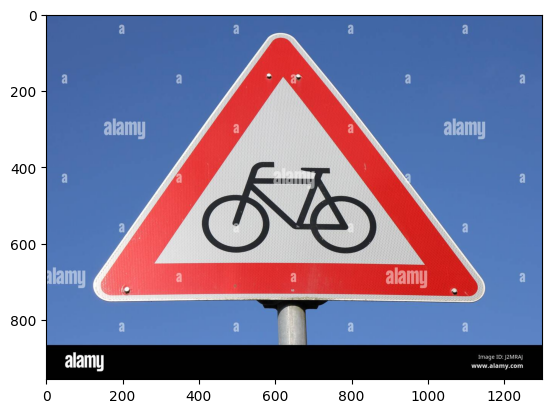

In [41]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


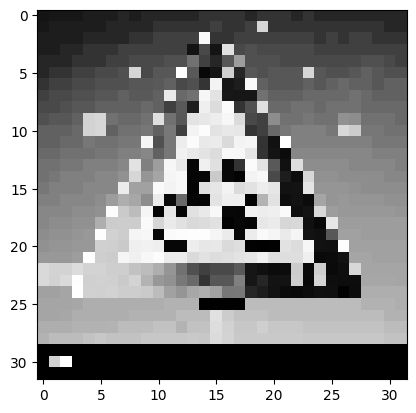

In [42]:
#Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [43]:
#Reshape reshape
img = img.reshape(1, 32, 32, 1)

In [51]:
#Test image
predictions = model.predict(img)
predicted_class = np.argmax(predictions, axis=1)
print("predicted sign: "+ str(predicted_class))

1/1 [==============================] - 0s 17ms/step
predicted sign: [29]


In [56]:
predictions = model.predict(img)
predicted_class = np.argmax(predictions, axis=1)

# Load the sign names
sign_names = data.set_index('ClassId')['SignName'].to_dict()

# Print the predicted sign number and its corresponding name
for prediction in predicted_class:
    print(f"Predicted sign number: {prediction}\nSign name: {sign_names[prediction]}")


1/1 [==============================] - 0s 55ms/step
Predicted sign number: 29
Sign name: Bicycles crossing
